In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ase import io as aio

from gas.PDFs.RDFs import RDF, quick_rdf
from gas.io.xyz import load_xyz

try:
    import cupy as cp
    if cp.cuda.is_available():
        print(f"Found {cp.cuda.runtime.getDeviceCount()} GPUs")
        device = 0
        print(f"Will use GPU {device}")
        cp.cuda.Device(device).use()
    else:
        print("No GPUs found, using CPU")
        device='cpu'
except (ImportError, ModuleNotFoundError):
    print("No GPUs found, using CPU")
    device='cpu'

Found 4 GPUs
Will use GPU 0


# a Ta

In [56]:
file_Ta = Path("/home/arthur/Data/PDFs/structures/a_Ta/Ta_sim_model.xyz")
assert file_Ta.exists()
material = "a_Ta"
pbcs = [1,1,1]

In [57]:
atoms = aio.read(file_Ta, format='prismatic')
atoms.set_pbc(pbcs)

# Haili's structures

In [59]:
matdir = Path("/data1/PDF/structures/C")
material = "C"
print("dir exists: ", matdir.exists())

files_all = sorted(list(matdir.glob("*.xyz")))
files_heated = sorted(list(matdir.glob("*heated.xyz")))
files_quenched = sorted(list(matdir.glob("*quenched.xyz")))
files_initial = sorted(list(matdir.glob("*initial.xyz")))
print("all files: ", [f.stem for f in files_all])

i = 0
f = files_all[i]

filter_pos = [None, None, None]
atoms = load_xyz(f, filter_pos=filter_pos)


dir exists:  True
all files:  ['C_5000K_50', 'C_rate15_heated', 'C_rate15_initial', 'C_rate15_quenched']
loading file: C_5000K_50.xyz
# atoms: 241224
Atoms(symbols='C241224', pbc=[True, True, False], cell=[109.06130535941813, 109.06130535941813, 270.2823635452572])


## GPU 

Cell size (A): [109.06130536 109.06130536 270.28236355]
Using a max radius of 20 A
reducing dr_ind from 1 -> 0.5
Num total atoms in sim = 241224
Num non-edge atoms = 193610
atomic density = 0.075 atoms / A^3
-- done --
Total time (h:m:s) 0:00:03.478
Center atoms per sec: 55_664.65



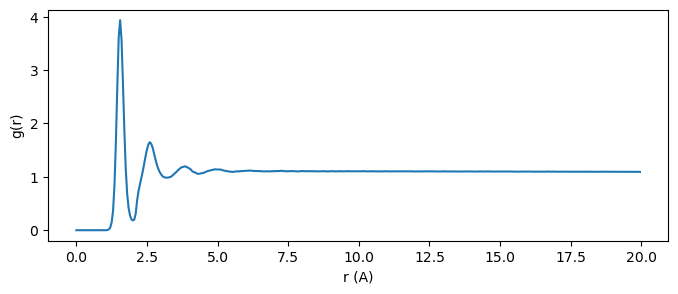

In [60]:
### The main variable here is batch_size, I have found that 25k is the roughly optimal
### value for my GPU. If running out of memory, decrease batch_size,
### if things are slow, increase skip
### For me, runs with skip=1, r_max=20 in ~ 4.6 seconds, ~225k centers/second

batch_size = 25_000

dr = 0.05
hist_r_max = 20
skip = 1

rdf = RDF(device=device, v=1)
r, gr = rdf.rdf(
    atoms,
    dr=dr,
    hist_r_max=hist_r_max,
    skip=skip,
    pbcs=atoms.get_pbc(),
    batch_size= batch_size,
    reduced=True,
)
r, gr = r.get(), gr.get()

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(r, gr)
ax.set_xlabel("r (A)")
ax.set_ylabel("g(r)")
plt.show()


## CPU 

In [8]:
device = 'cpu'

Cell size (A): [268.6053 268.6053 268.6053]
Using a max radius of 20 A
starting KD Tree
KDTree calc time: 3.6e+00 s
Num total atoms in sim = 1023999
Skip = 100, so calculating using 10240 atoms as centers


100%|██████████| 10240/10240 [00:02<00:00, 3565.51it/s]


-- done --
Total time (h:m:s) 0:00:06.503
Center atoms per sec: 1574.7



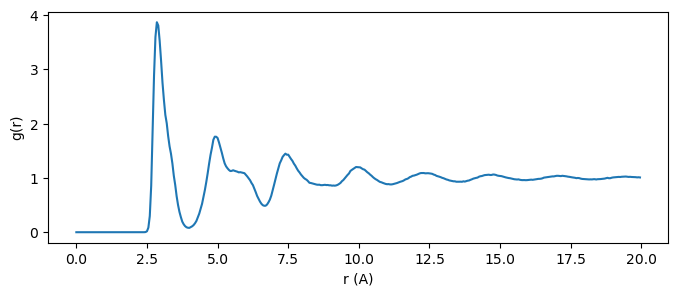

In [9]:
### here using a KDtree search, generally better for larger radii and fewer centers
### set "skip" to sample the centerpoints used

dr = 0.05
hist_r_max = 20
skip = 100

rdf = RDF(device=device, v=1)
r, gr = rdf.rdf_cpu(
    atoms,
    dr=dr,
    hist_r_max=hist_r_max,
    skip=skip,
    pbcs=pbcs,
    reduced=True,
)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(r, gr)
ax.set_xlabel("r (A)")
ax.set_ylabel("g(r)")
plt.show()


Cell size (A): [268.6053 268.6053 268.6053]
Using a max radius of 20 A
starting KD Tree
KDTree calc time: 3.3e+00 s
Num total atoms in sim = 1023999
Skip = 100, so calculating using 10240 atoms as centers


100%|██████████| 10240/10240 [00:02<00:00, 3550.54it/s]


-- done --
Total time (h:m:s) 0:00:06.171
Center atoms per sec: 1659.4



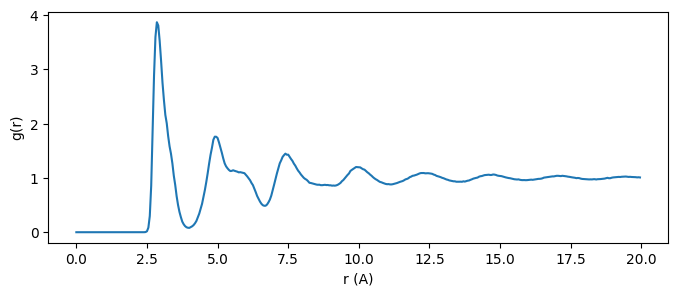

In [ ]:
### here using a KDtree search, generally better for larger radii and fewer centers
### set "skip" to sample the centerpoints used

dr = 0.05
hist_r_max = 20
skip = 100

rdf = RDF(device=device, v=1)
r, gr = rdf.rdf_cpu(
    atoms,
    dr=dr,
    hist_r_max=hist_r_max,
    skip=skip,
    pbcs=pbcs,
    reduced=True,
)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(r, gr)
ax.set_xlabel("r (A)")
ax.set_ylabel("g(r)")
plt.show()


100%|██████████| 10240/10240 [00:01<00:00, 5655.17it/s]


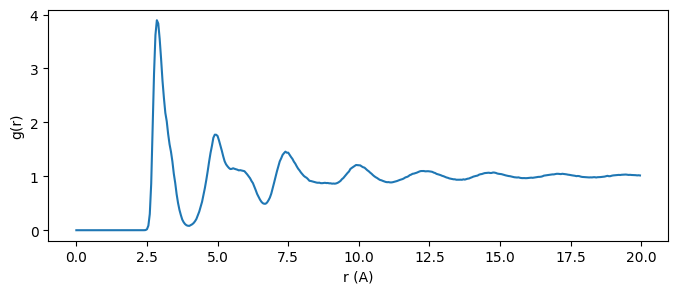

In [10]:
### here using a volumetric search, faster in other cases

dr = 0.05
hist_r_max = 20
skip = 100

r, Gr, gr = quick_rdf(
    atoms,
    dr=dr,
    hist_r_max=hist_r_max,
    skip=skip,
    pbcs=pbcs,
)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(r, gr)
ax.set_xlabel("r (A)")
ax.set_ylabel("g(r)")
plt.show()
